# Colorspace exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imagine.color import conversion

In [2]:
df = pd.read_csv("preprocessed/colors.csv", na_values=-1).dropna().convert_dtypes()
df

id  skin_r  skin_g  skin_b  hair_r  hair_g  hair_b  lips_r  \
0    tKGcZvehYuM     177     133     128      21      21      21     166   
1    10pn1m9I-Ng      77      46      37       0       0       0     102   
2    EPwG8SijLnY     194     144     115      53      42      36     176   
3    GpQhFtH4lFM     176     121     109      27       8      14     175   
4    es2nGInaFYE     166     136     132     116      98      78     148   
..           ...     ...     ...     ...     ...     ...     ...     ...   
955  B8h-giS3ArE     179     133     116      52      37      31     167   
956  eATX104iwFc     218     168     133      19       3       2     211   
957  llbdfAwpHvw     189     153     146      91      76      68     167   
958  JMgGXBSybXE     197     139     122      33      27      25     183   
959  EGb_TN_3yZo     211     166     155      81      50      43     188   

     lips_g  lips_b  ...  lipstick_b  eyeshadow0_r  eyeshadow0_g  \
0        99     100  ...         101            84            70   
1        48      42  ...          39            40            24   
2       110     106  ...          34            61            41   
3       107     121  ...          46           113            66   
4        84     101  ...          58            70            46   
..      ...     ...  ...         ...           ...           ...   
955      81      91  ...          51           105            46   
956     111     118  ...          66            56            20   
957      88     103  ...          96            80            46   
958     100     107  ...         113           114            74   
959     113     123  ...         120            88            51   

     eyeshadow0_b  eyeshadow1_r  eyeshadow1_g  eyeshadow1_b  eyeshadow2_r  \
0              70           122            98            94           155   
1              18            73            56            51           102   
2              45           123            89            86           198   
3              59           139            87            73           174   
4              45           114            79            74           145   
..            ...           ...           ...           ...           ...   
955            44           145            90            87           197   
956            19           111            64            54           155   
957            41           112            69            65           134   
958            59           142            97            82           180   
959            53           183           118           121           243   

     eyeshadow2_g  eyeshadow2_b  
0             123           115  
1              74            65  
2             161           144  
3             130           150  
4             112           105  
..            ...           ...  
955           151           130  
956           103            86  
957            88            81  
958           131           119  
959           201           208  

[960 rows x 25 columns]

In [3]:
def show_row(row, scale=2):
    def show_color(color_array, name, axis):
        axis.imshow([[color_array]])
        axis.set_title(name)
        axis.set_axis_off()
        
    n = len(row) // 3
    
    fig, axs = plt.subplots(1, n, figsize=(n*scale, scale))
    fig.suptitle(row[0])
    for i in range(n):
        color = row[3*i + 1 : 3*i + 4]
        show_color(np.array(color, dtype=np.uint8), color.index[0].partition('_')[0], axs[i])
        
    plt.tight_layout()
    plt.show()

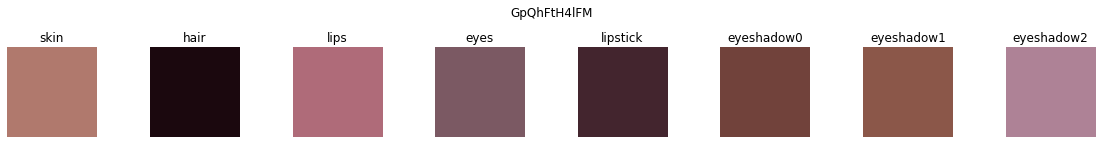

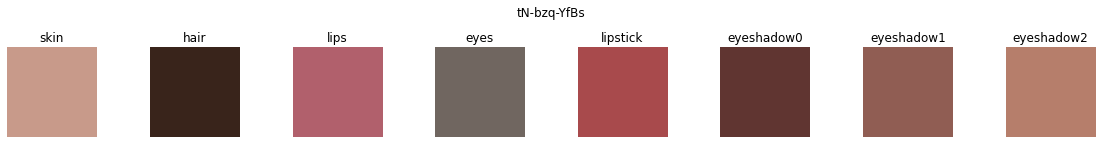

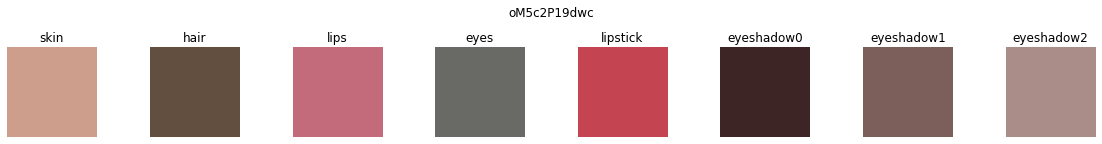

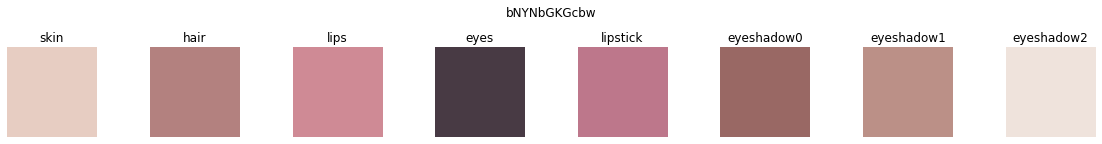

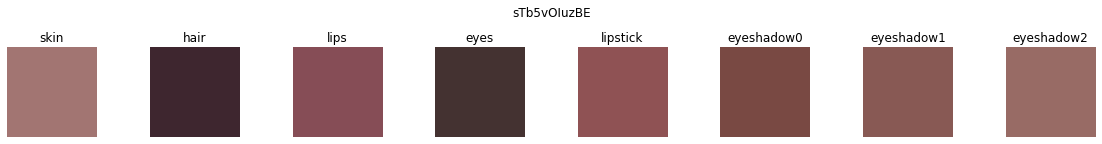

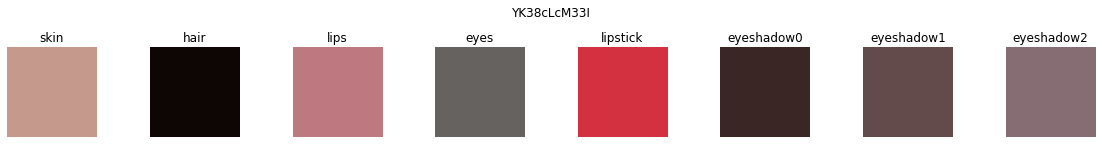

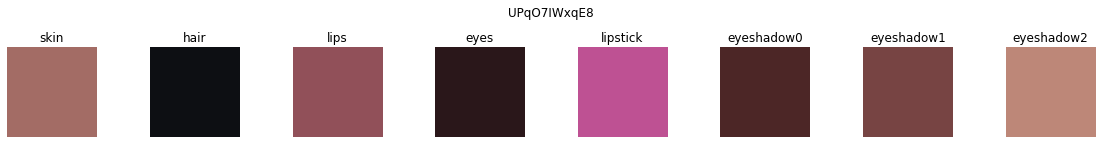

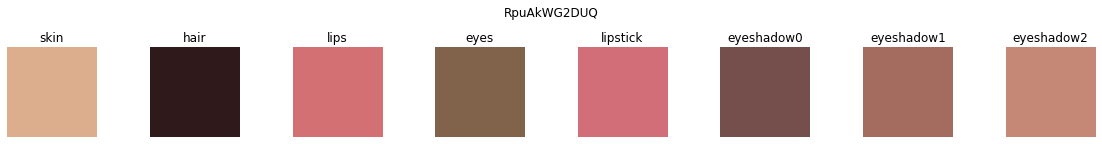

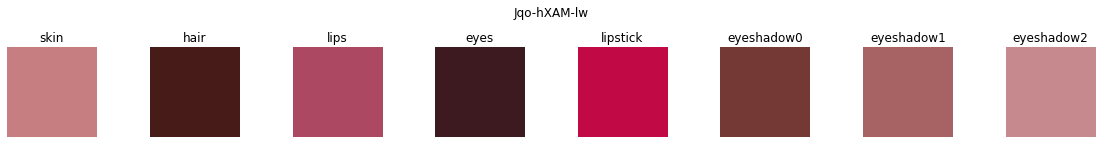

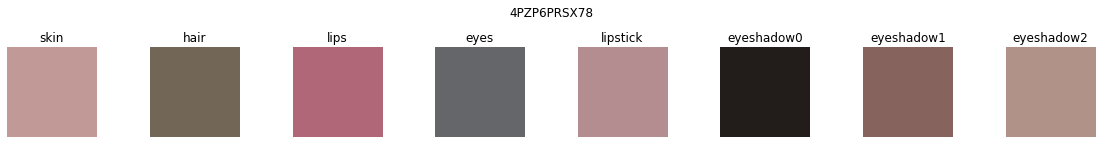

In [4]:
for _, row in df.sample(10).iterrows():
    show_row(row)

In [5]:
parts = {
    "skin" : df.iloc[:, 1:4],
    "hair" : df.iloc[:, 4:7],
    "lips" : df.iloc[:, 7:10],
    "eyes" : df.iloc[:, 10:13],
    "lipstick" : df.iloc[:, 13:16],
    "eyeshadow" : df.iloc[:, 16:19]
}

face_parts = {p: parts[p] for p in ["skin", "hair", "lips", "eyes"]}
makeup_parts = {p: parts[p] for p in ["lipstick", "eyeshadow"]}

In [6]:
def rgb_to_lab_df(df):
    lookup = ["l", "a", "b"]
    return pd.DataFrame(conversion.RgbToLab(df.values[None, ...].astype(np.uint8))[0],
                        columns=["{}_{}".format(c.partition('_')[0], lookup[i]) for i, c in enumerate(df.columns)],
                        index=df.index)

In [7]:
lab_parts = {k: rgb_to_lab_df(v) for k,v in parts.items()}
face_lab_parts = {p: lab_parts[p] for p in ["skin", "hair", "lips", "eyes"]}
makeup_lab_parts = {p: lab_parts[p] for p in ["lipstick", "eyeshadow"]}

In [8]:
face_columns_lab = ["{}_{}".format(p, c) for p in ["skin", "eyes", "hair", "lips"] for c in ["l", "a", "b"]]
makeup_columns_lab = ["{}_{}".format(p, c) for p in ["lipstick", "eyeshadow0"] for c in ["l", "a", "b"]]

### Space of each color feature

In [9]:
def show_colorspace(pixels, name=None, scale=15):
    pixels_array = np.array(pixels, dtype=np.uint8)
    pixels_lab = conversion.RgbToLab(pixels_array[None, ...])[0]
    
    fig = plt.figure(figsize=(scale, scale))
    if name is not None:
        fig.suptitle(name)
    ax = fig.add_subplot(2, 2, 1, title="L channel histogram", xlabel="L")
    ax.hist(pixels_lab[..., 0], bins=64)
    ax = fig.add_subplot(2, 2, 2, title="LAB color space", projection='3d', 
                         xlabel="A", ylabel="B", zlabel="L")
    ax.scatter(pixels_lab[..., 1], pixels_lab[..., 2], pixels_lab[..., 0], facecolors=pixels_array/255.)
    ax = fig.add_subplot(2, 2, 3, xlabel="A", ylabel="L", ylim=[0,255])
    ax.scatter(pixels_lab[..., 1], pixels_lab[..., 0], facecolors=pixels_array/255.)
    ax = fig.add_subplot(2, 2, 4, xlabel="B", ylabel="L", ylim=[0,255])
    ax.scatter(pixels_lab[..., 2], pixels_lab[..., 0], facecolors=pixels_array/255.)
    plt.tight_layout()
    plt.show()

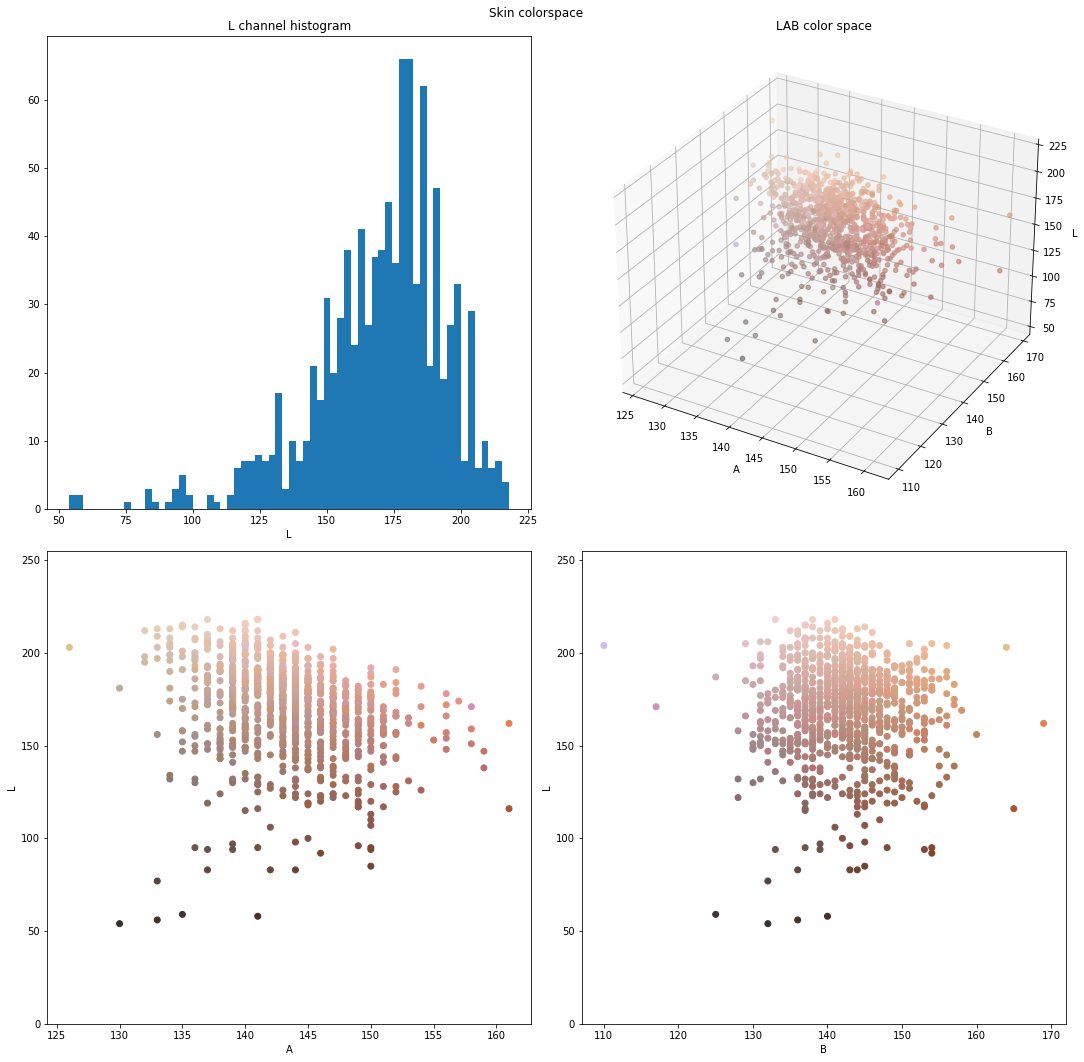

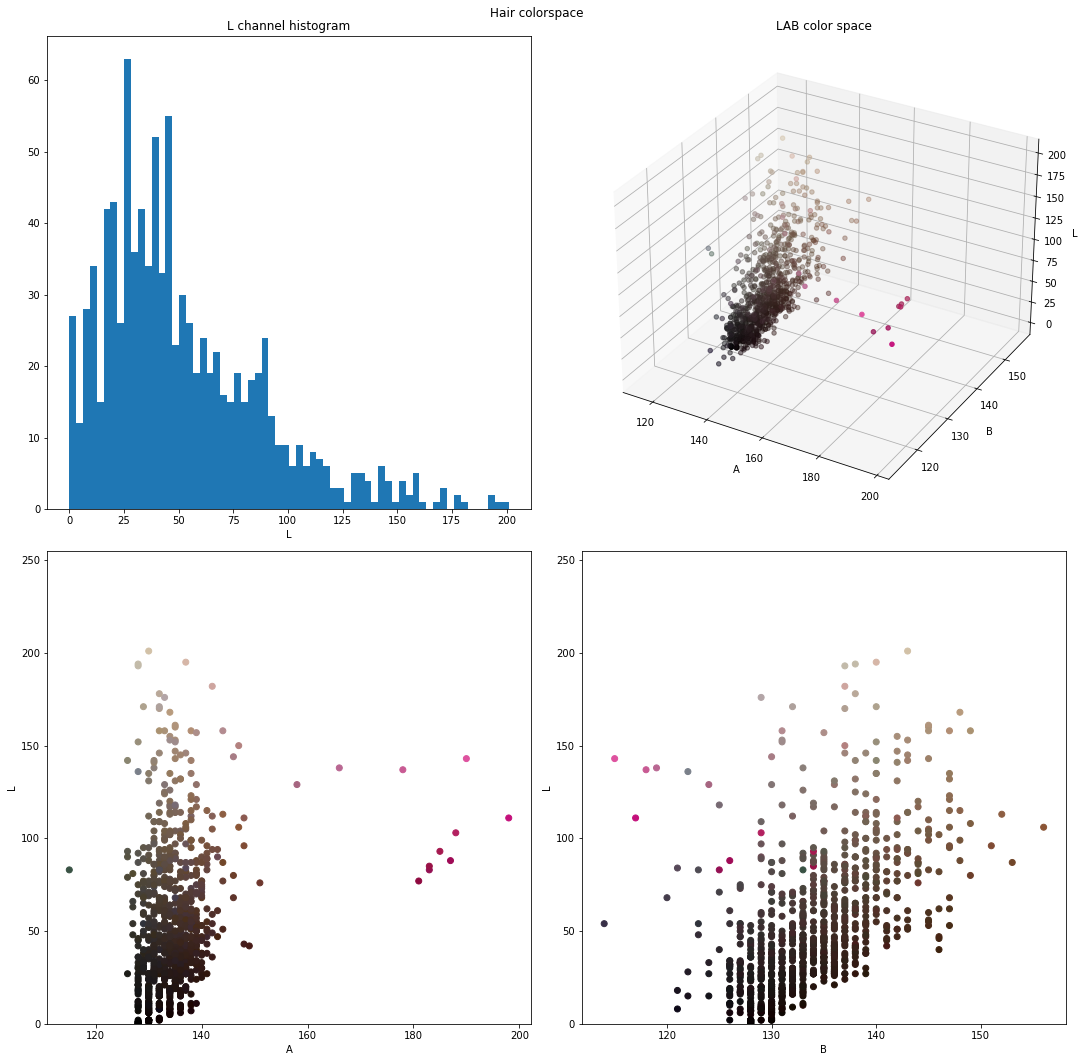

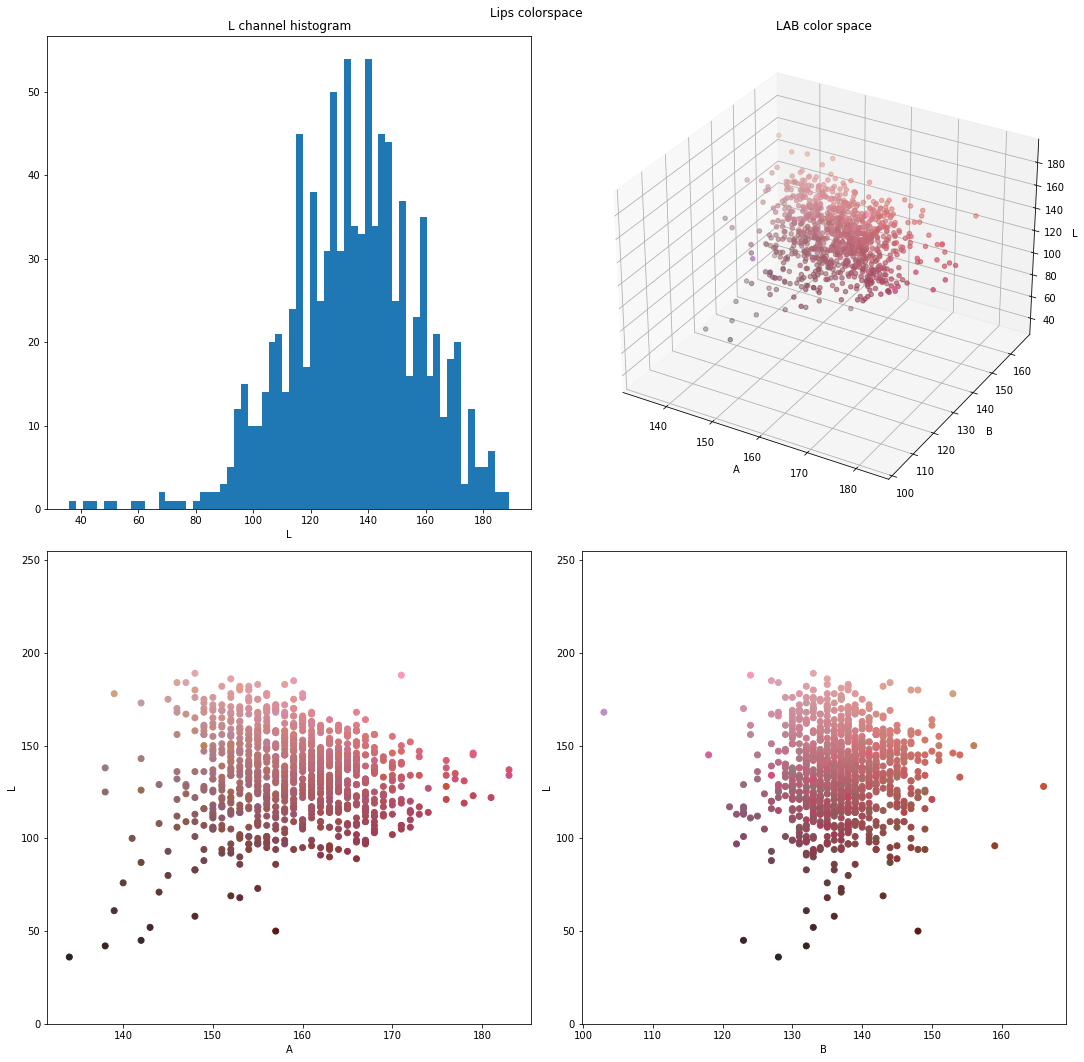

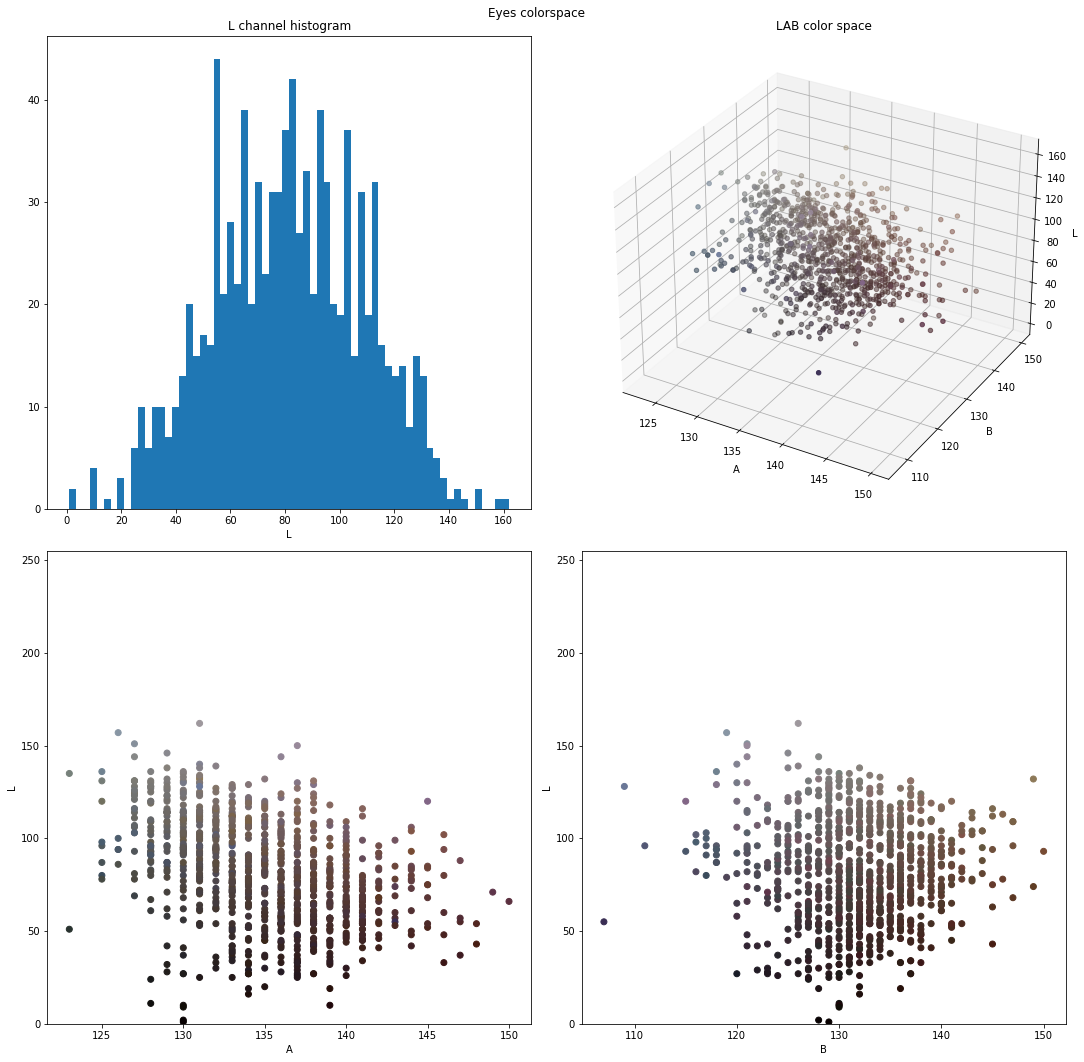

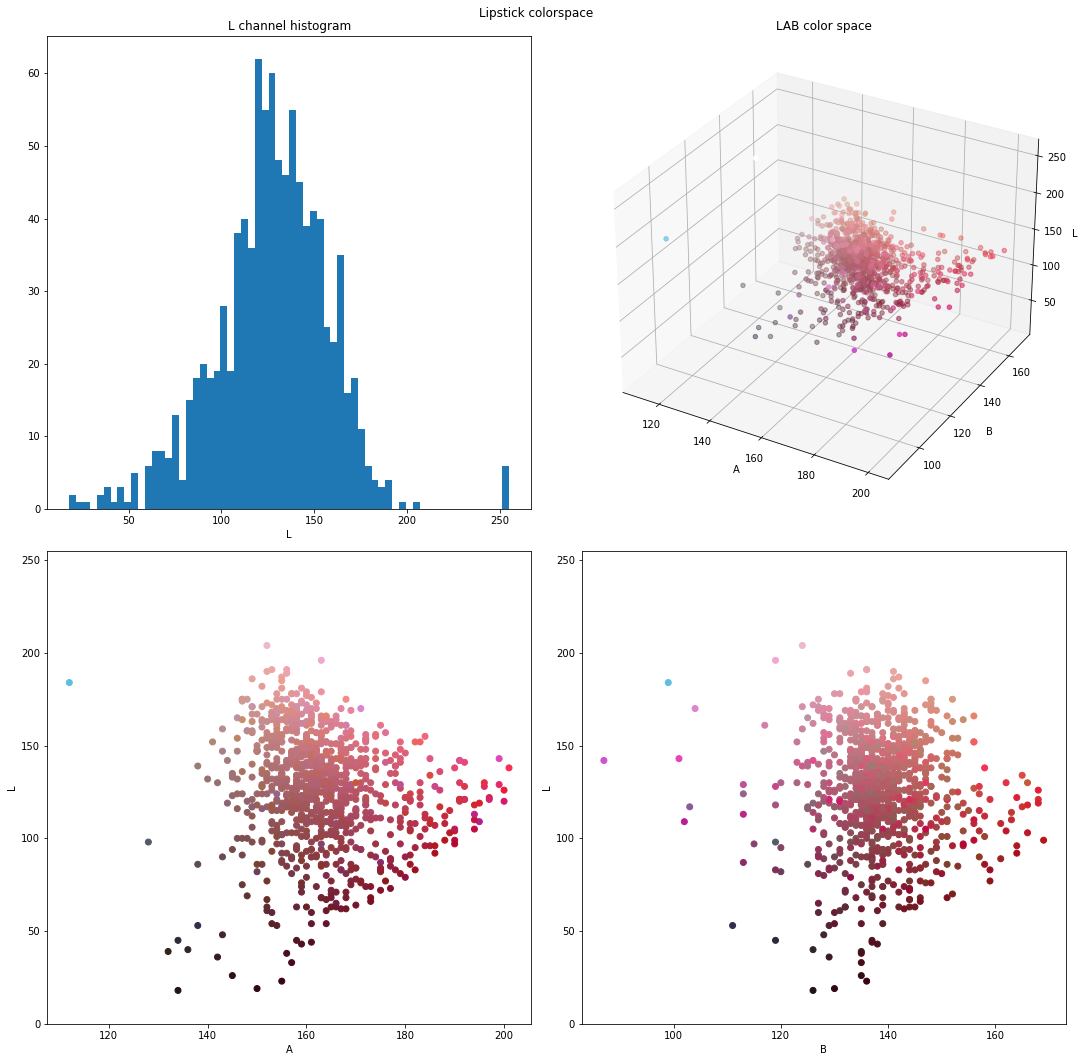

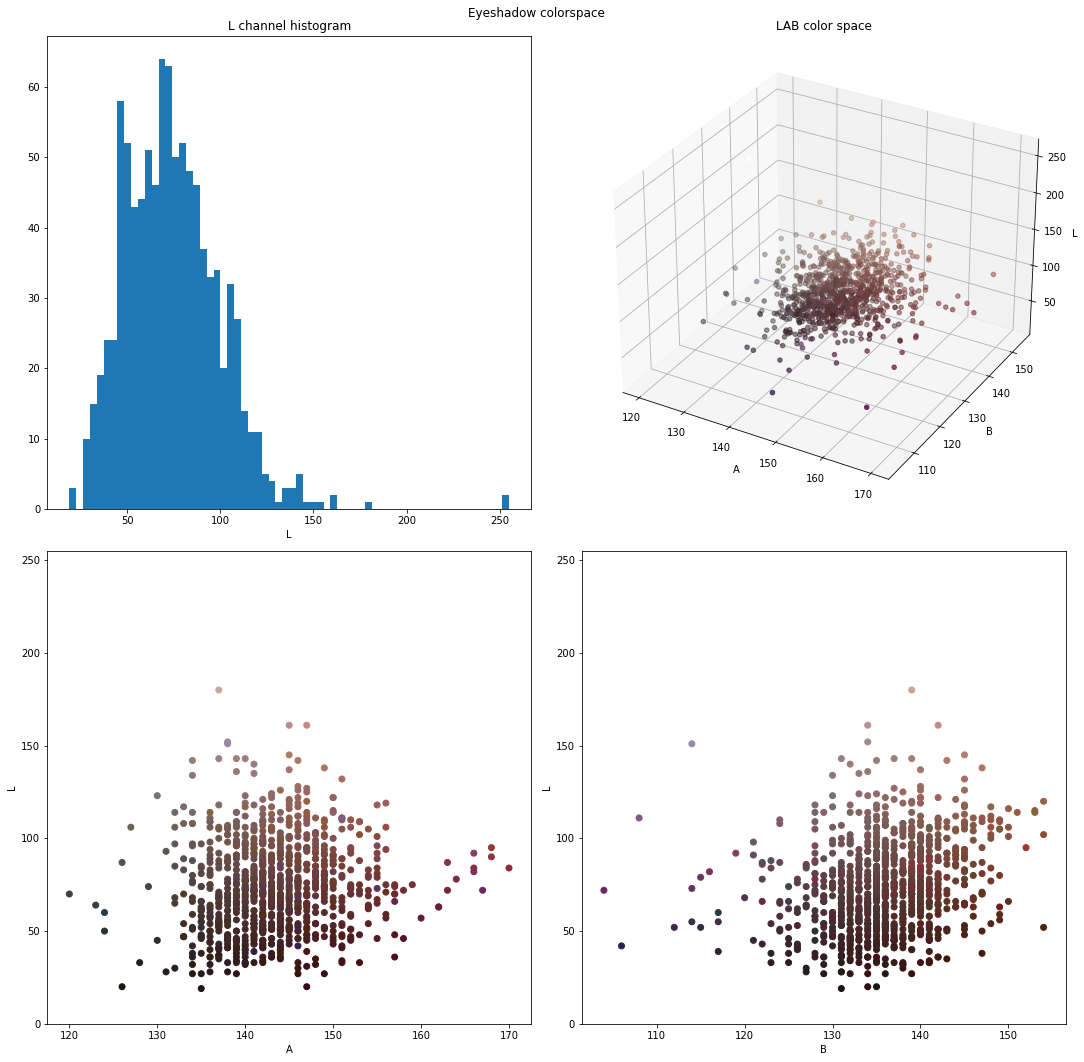

In [10]:
for name, color in parts.items():
    show_colorspace(color, "{} colorspace".format(name.capitalize()))

### Face colors against makeup colors

In [11]:
def show_scatter_matrix(d1, d2, name, scale=15, colors=None):
    plt.figure(figsize=(scale, scale))
    g = sns.PairGrid(pd.concat([d1, d2], axis=1).astype(np.float), x_vars=d2.columns, y_vars=d1.columns, height=scale/3)
    g.map(sns.scatterplot) if colors is None else g.map(sns.scatterplot, c=colors)
    plt.suptitle(name)
    plt.tight_layout()
    plt.show()

<Figure size 1080x1080 with 0 Axes>

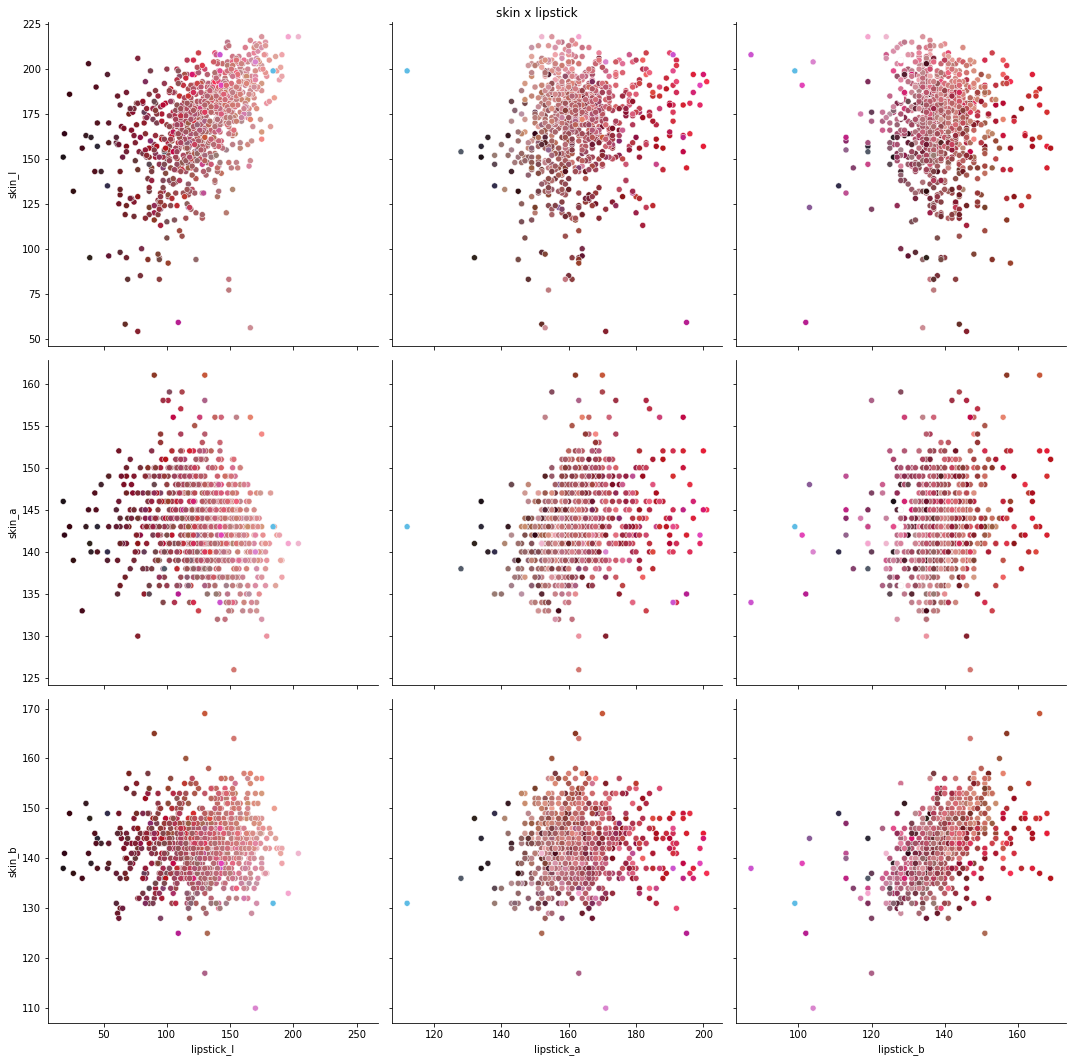

<Figure size 1080x1080 with 0 Axes>

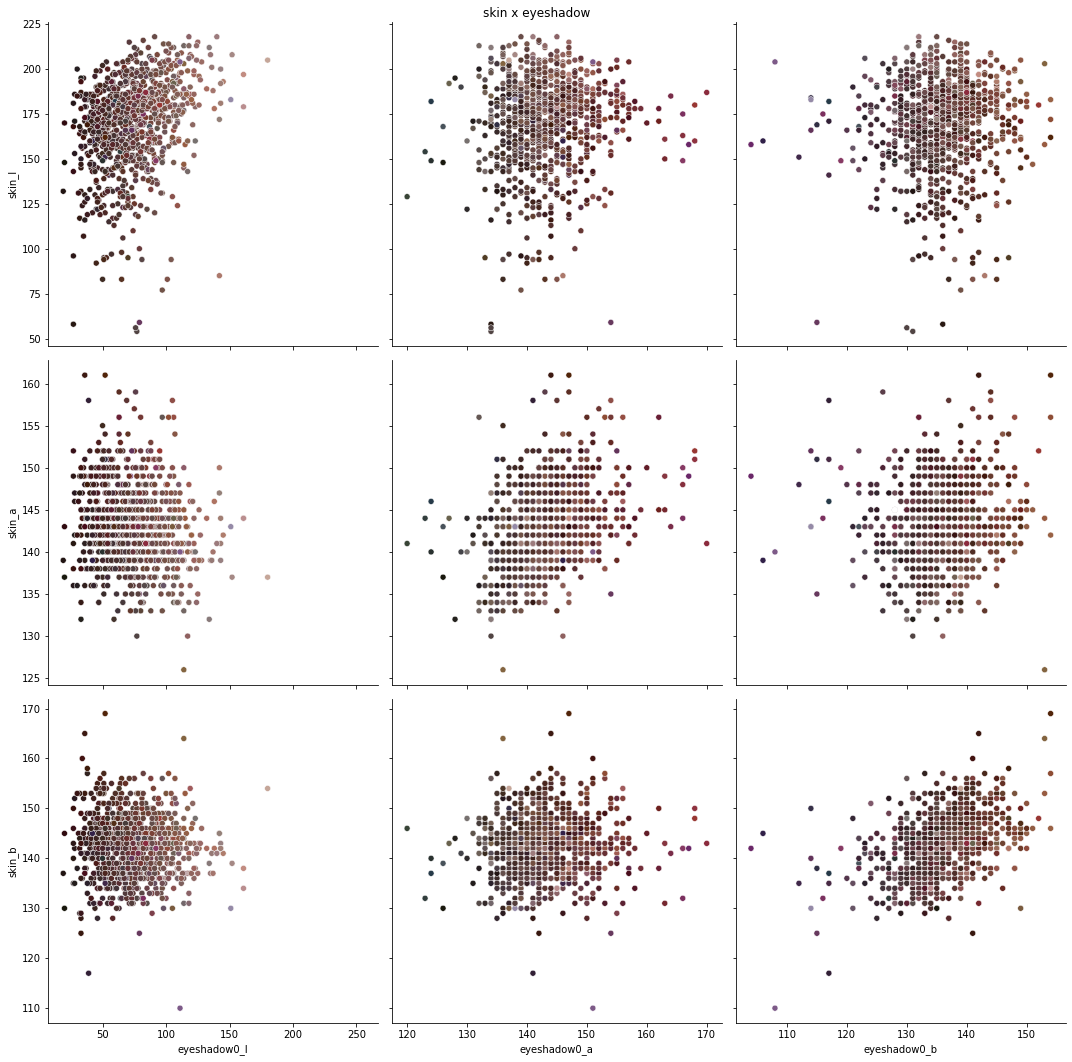

<Figure size 1080x1080 with 0 Axes>

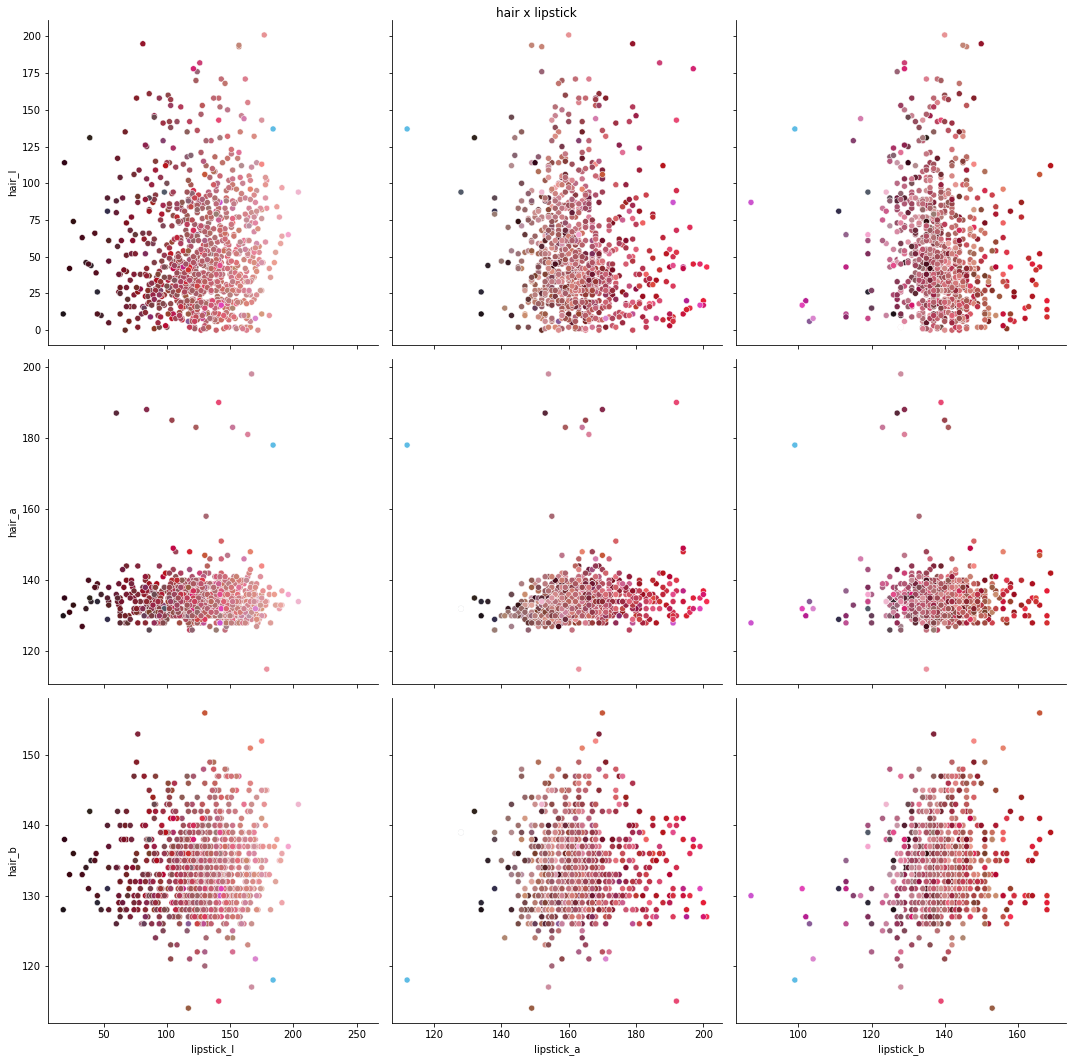

<Figure size 1080x1080 with 0 Axes>

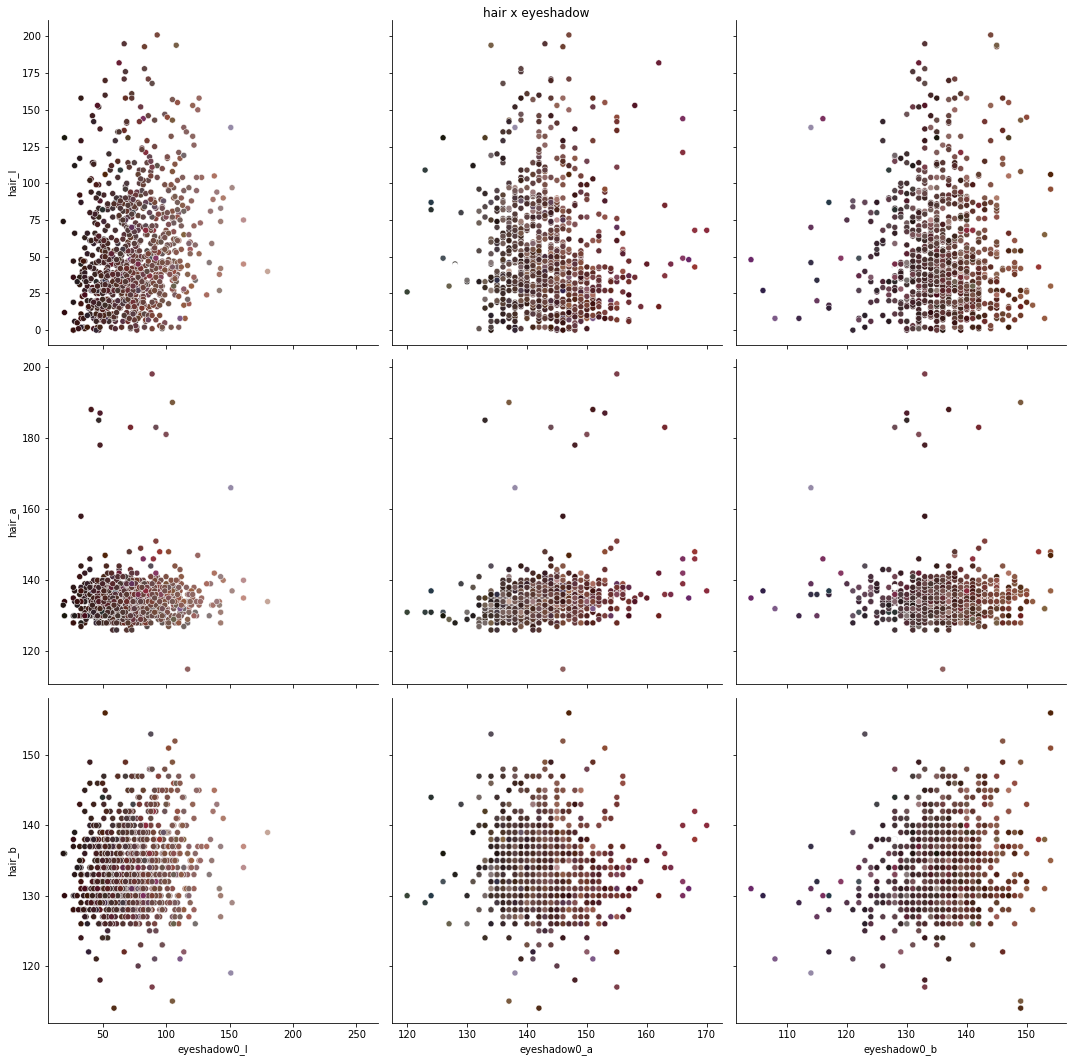

<Figure size 1080x1080 with 0 Axes>

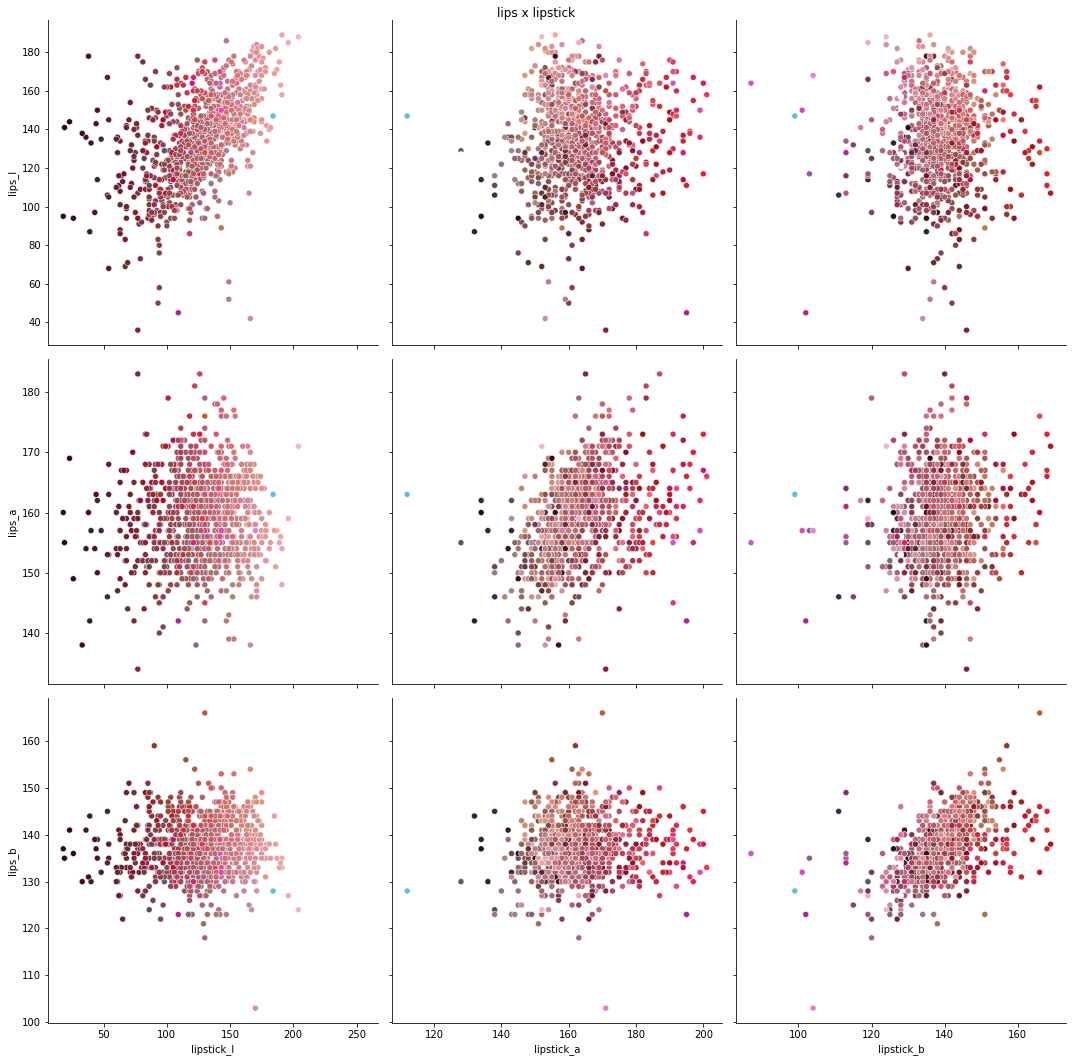

<Figure size 1080x1080 with 0 Axes>

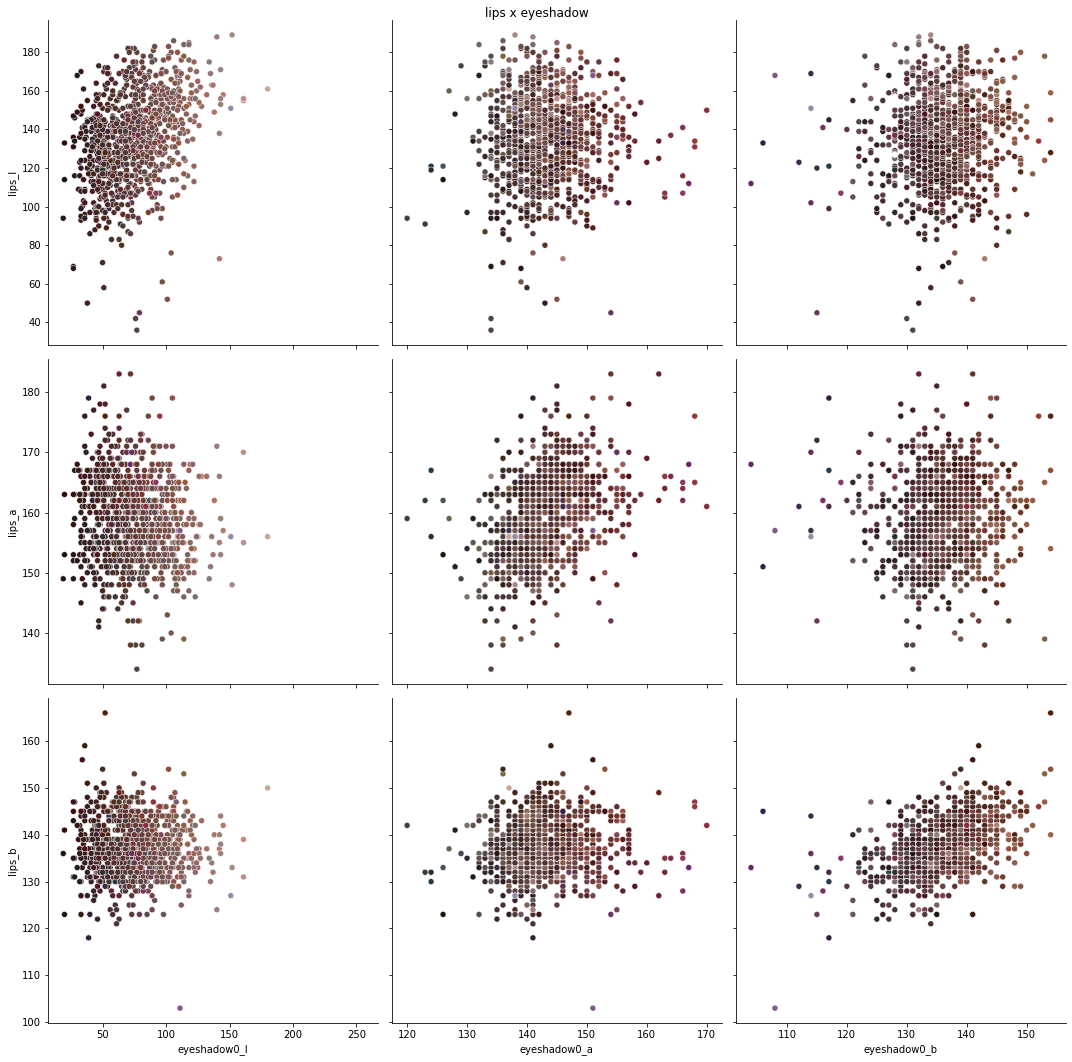

<Figure size 1080x1080 with 0 Axes>

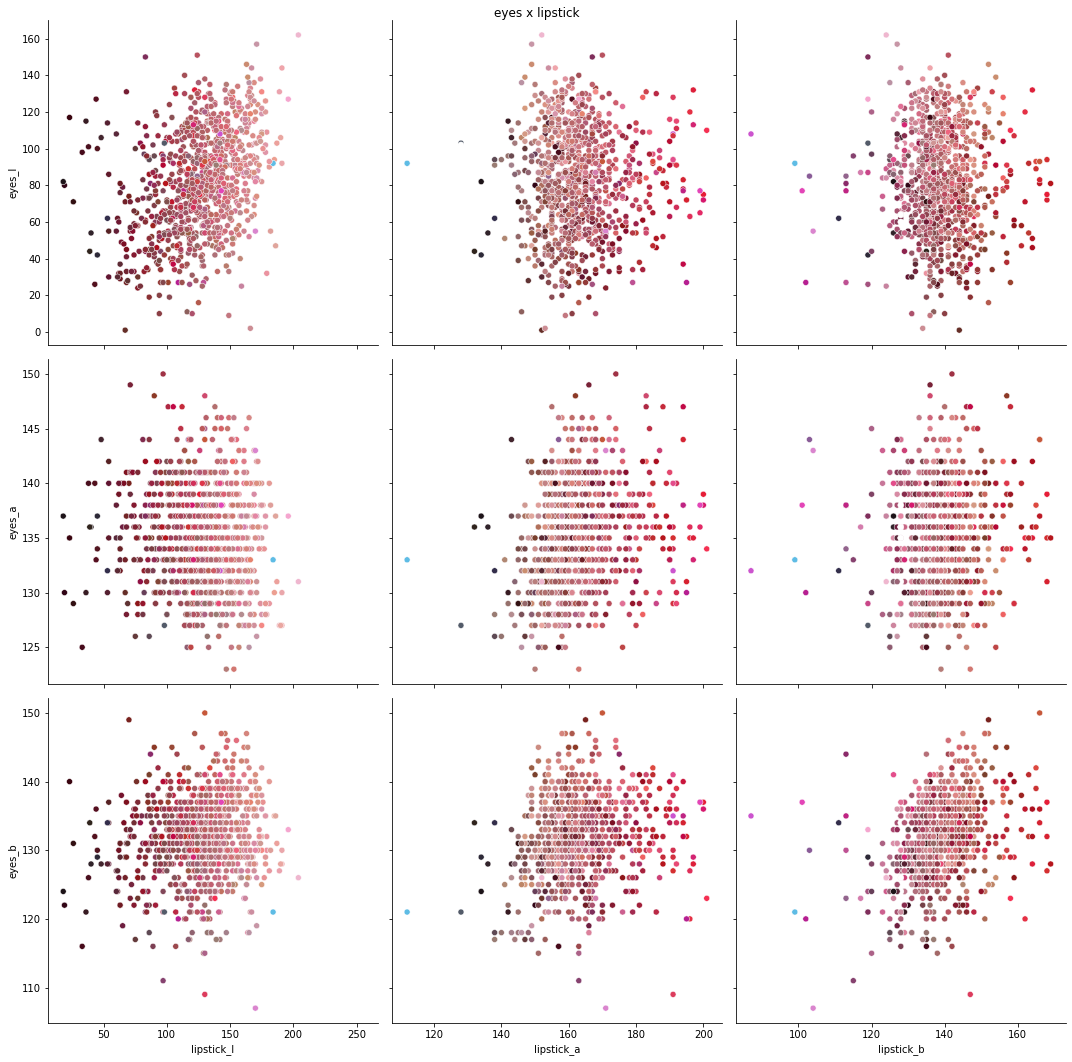

<Figure size 1080x1080 with 0 Axes>

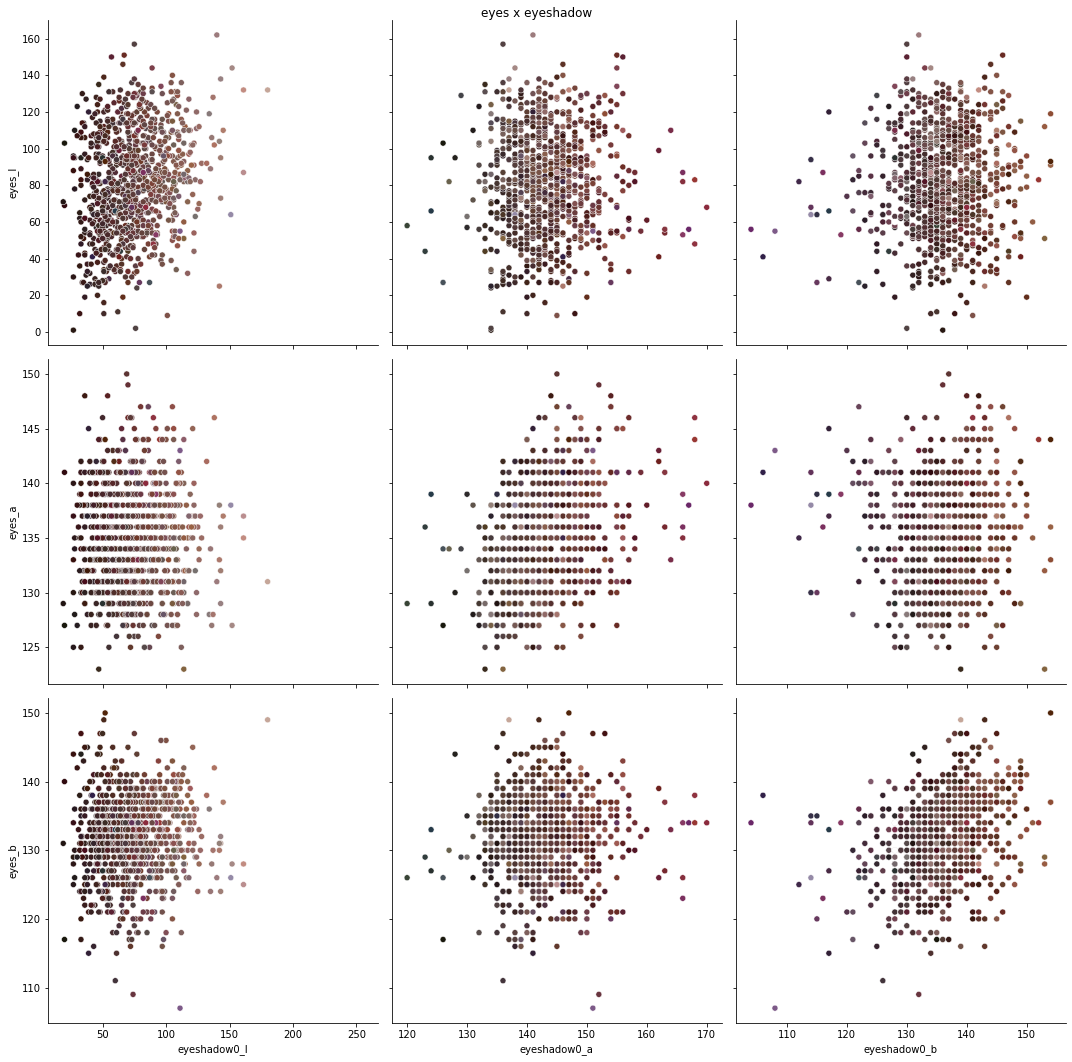

In [12]:
import itertools
for (name1, part1), (name2, part2) in itertools.product(face_lab_parts.items(), makeup_lab_parts.items()):
    show_scatter_matrix(part1, part2, "{} x {}".format(name1, name2), colors=makeup_parts[name2].values/255.)

### Correlations

In [13]:
def show_correlation_heatmap(df, columns_x, columns_y, scale=15):
    fig, (ax, cbar_ax) = plt.subplots(1, 2, figsize=(scale, scale*0.4), gridspec_kw={"width_ratios": (.9, .05)})
    sns.heatmap(df.corr().loc[columns_y, columns_x], vmin=-1, vmax=1, center=0, square=True, ax=ax, cbar_ax=cbar_ax)
    plt.tight_layout()
    plt.show()

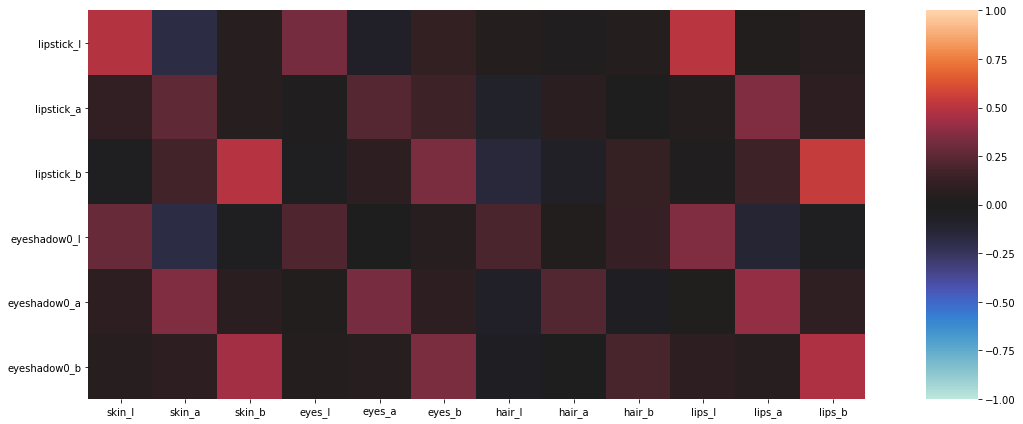

In [14]:
show_correlation_heatmap(pd.concat(lab_parts.values(), axis=1), face_columns_lab, makeup_columns_lab)